In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'



### main.py是分类模型在整个测试集运行，不包含可视化、结果分析和去除未出现类别后的测试集测试的代码
### 其他附件代码为完成汇报所需的可视化、结果分析等，包含重复的代码

#### 读取数据

In [2]:
train_data = pd.read_csv('KDDTrain+.txt', sep=',',header= None)

train_data.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
            'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
            'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
            'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
            'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome', 'level']

train_data = train_data.dropna()
train_data.head()
test_data = pd.read_csv('KDDTest+.txt', sep=',',header= None)
test_data.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
            'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
            'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
            'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
            'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome', 'level']

test_data = test_data.dropna()
test_data.shape

d:\anaconda\envs\ML\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (25,26,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
d:\anaconda\envs\ML\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(22542, 43)

#### 将字符串数字转化成文本

In [3]:
text_columns = train_data.select_dtypes(include=['object'])
print(text_columns.head())

text_columns = test_data.select_dtypes(include=['object'])
print(text_columns.head())
train_data["dst_host_srv_rerror_rate"] = train_data["dst_host_srv_rerror_rate"].apply(pd.to_numeric, errors='coerce')
train_data["srv_serror_rate"] = train_data["srv_serror_rate"].apply(pd.to_numeric, errors='coerce')
train_data["rerror_rate"] = train_data["rerror_rate"].apply(pd.to_numeric, errors='coerce')
train_data = train_data.reset_index()
text_columns = train_data.select_dtypes(include=['object'])
print(text_columns.head())


test_data["dst_host_srv_rerror_rate"] = test_data["dst_host_srv_rerror_rate"].apply(pd.to_numeric, errors='coerce')
text_columns = test_data.select_dtypes(include=['object'])
test_data = test_data.reset_index()
print(text_columns.head())

#print(train_data.isna().sum().sum())

  protocol_type   service flag srv_serror_rate rerror_rate  \
0           tcp  ftp_data   SF            0.00        0.00   
1           udp     other   SF            0.00        0.00   
2           tcp   private   S0            1.00        0.00   
3           tcp      http   SF            0.20        0.00   
4           tcp      http   SF            0.00        0.00   

  dst_host_srv_rerror_rate  outcome  
0                     0.00   normal  
1                     0.00   normal  
2                     0.00  neptune  
3                     0.01   normal  
4                     0.00   normal  
  protocol_type   service  flag dst_host_srv_rerror_rate  outcome
0           tcp   private   REJ                     1.00  neptune
1           tcp   private   REJ                     1.00  neptune
2           tcp  ftp_data    SF                     0.00   normal
3          icmp     eco_i    SF                     0.00    saint
4           tcp    telnet  RSTO                     0.71    mscan
  p

#### 至此，获得干净的元数据，train_data,test_data,开始可视化

In [4]:
def generate_gradient_colors(start_color, end_color, num_colors):
    """
    生成渐变颜色列表

    参数:
    start_color (tuple): 开始颜色，包含(r, g, b)的元组，每个分量取值范围为0到255。
    end_color (tuple): 结束颜色，包含(r, g, b)的元组，每个分量取值范围为0到255。
    num_colors (int): 要生成的渐变颜色数量。

    返回:
    list: 包含渐变颜色的列表，每个颜色表示为(r, g, b)的元组。
    """
    gradient_colors = []

    # 计算颜色渐变步长
    r_step = (end_color[0] - start_color[0]) / (num_colors - 1)
    g_step = (end_color[1] - start_color[1]) / (num_colors - 1)
    b_step = (end_color[2] - start_color[2]) / (num_colors - 1)

    # 生成渐变颜色
    for i in range(num_colors):
        r = start_color[0] + i * r_step
        g = start_color[1] + i * g_step
        b = start_color[2] + i * b_step
        gradient_colors.append((r/255, g/255, b/255))

    return gradient_colors
print(generate_gradient_colors((44,65,80), (181,211,217), 4))

[(0.17254901960784313, 0.2549019607843137, 0.3137254901960784), (0.35163398692810455, 0.4457516339869281, 0.49281045751633984), (0.5307189542483659, 0.6366013071895424, 0.6718954248366013), (0.7098039215686275, 0.8274509803921568, 0.8509803921568627)]


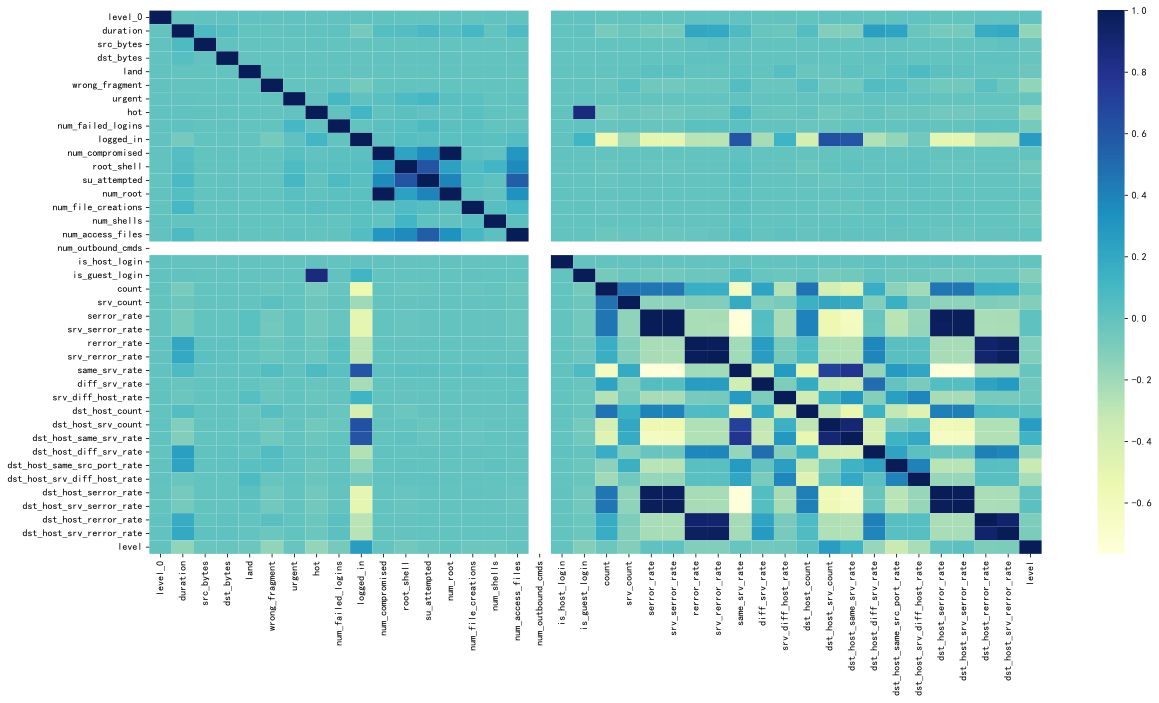

,level_0,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
0,0,0,491,0,0,0,0,0,0,0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20.0
1,1,0,146,0,0,0,0,0,0,0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15.0
2,2,0,0,0,0,0,0,0,0,0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19.0
3,3,0,232,8153,0,0,0,0,0,1,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21.0
4,4,0,199,420,0,0,0,0,0,1,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21.0


In [5]:
numeric_columns = train_data.select_dtypes(include=['number']).reset_index()
numeric_columns.head()
del numeric_columns["index"]
correlation_matrix = numeric_columns.corr()
#custom_cmap = mcolors.ListedColormap([(44/255,65/255,80/255),(111/255,160/255,172/255),(181/255,211/255,217/255),(252/255,238/255,226/255),(93/255,136/255,123/255)])
#sns.heatmap(correlation_matrix, annot=False, cmap=custom_cmap)
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, annot=False, cmap="YlGnBu")
# 添加标题

#sns.heatmap(data.corr(), annot=True, cmap="YlGnBu")
#plt.title('数字特征热力图')
# 显示热力图
plt.show()
numeric_columns.head()

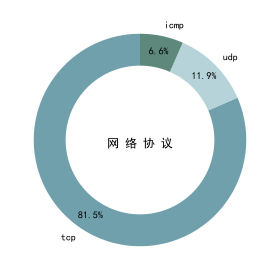

In [6]:
protocol_type = train_data["protocol_type"].value_counts().to_dict()

# 饼图标签
labels = protocol_type.keys()

# 饼图数据
sizes = protocol_type.values()

# 颜色
colors = [(111/255,160/255,172/255), (181/255,211/255,217/255),(93/255,136/255,123/255)]

# 爆炸（可选，用于突出显示某个块）
explode = (0.0, 0, 0)

# 创建饼图
plt.figure(dpi = 300)
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

# 添加一个中心圆，使饼图看起来更像一个环形图
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# 饼图标题
plt.title('网 络 协 议',loc = 'center',y=0.45)

# 显示饼图
#plt.axis('equal')  # 保证饼图是圆形而不是椭圆
plt.tight_layout()
plt.show()


[53600, 12434, 1309]
[49084, 2559, 6982]


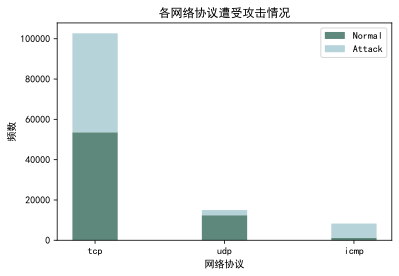

In [7]:
two_df = train_data[["protocol_type","outcome"]]
two_df.head()
normal_count = []
attack_count = []
name_list = list(train_data["protocol_type"].unique())
for i in name_list:
    normal_count.append(two_df[two_df["protocol_type"] == i]["outcome"].value_counts()["normal"])
    attack_count.append(len(two_df[two_df["protocol_type"] == i]["outcome"])-two_df[two_df["protocol_type"] == i]["outcome"].value_counts()["normal"])
print(normal_count)
print(attack_count)
categories =    name_list
bottom_data = normal_count
top_data = attack_count

# 创建柱状图
fig, ax = plt.subplots()

# 设置每个柱子的宽度
bar_width = 0.35

# 生成柱子的位置
x = np.arange(len(categories))

# 绘制底部柱子
ax.bar(x, bottom_data, bar_width, label='Normal', color=(93/255,136/255,123/255))

# 绘制顶部柱子，位置稍微向上偏移
ax.bar(x, top_data, bar_width, label='Attack', color=(181/255,211/255,217/255), bottom=bottom_data)

# 添加标签和标题
ax.set_xlabel('网络协议')
ax.set_ylabel('频数')
ax.set_title('各网络协议遭受攻击情况')

# 添加图例
ax.legend()

# 设置x轴标签
ax.set_xticks(x)
ax.set_xticklabels(categories)

plt.show()

{'SF': 74945, 'S0': 34847, 'REJ': 11232, 'others': 4944}


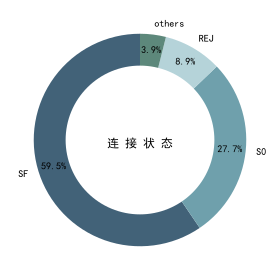

In [8]:
flag = train_data["flag"].value_counts().to_dict()
flag = dict(sorted(flag.items(), key=lambda item: item[1], reverse=True))


draw_flag = {}
others = 0
for i in range(len(flag)):
    if i <=2:
        draw_flag[list(flag.keys())[i]] = list(flag.values())[i]
    else:
        others = others + list(flag.values())[i]
draw_flag["others"] = others
print(draw_flag)
# 饼图标签
labels = draw_flag.keys()

# 饼图数据
sizes = draw_flag.values()

# 颜色
colors = [(66/255,97.5/255,120/255),(111/255,160/255,172/255), (181/255,211/255,217/255),(93/255,136/255,123/255)]

# 爆炸（可选，用于突出显示某个块）
#explode = (0.0, 0, 0)

# 创建饼图
plt.figure(dpi = 300)
plt.pie(sizes, labels=labels,autopct='%1.1f%%', startangle=90,colors = colors,pctdistance=0.85)

# 添加一个中心圆，使饼图看起来更像一个环形图
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# 饼图标题
plt.title('连 接 状 态',loc = 'center',y=0.45)

# 显示饼图
#plt.axis('equal')  # 保证饼图是圆形而不是椭圆
plt.tight_layout()
plt.show()

[63393, 354, 2693, 903]
[11552, 34493, 8539, 4041]
['SF', 'S0', 'REJ', 'others']


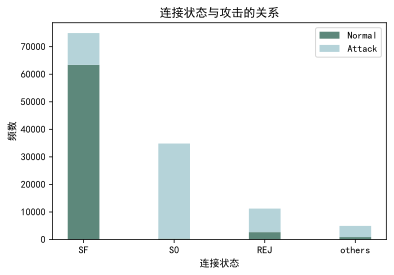

In [9]:
two_df = train_data[["flag","outcome"]]
two_df.head()
normal_count = []
attack_count = []
name_list = list(train_data["flag"].unique())
for i in name_list:
    normal_count.append(two_df[two_df["flag"] == i]["outcome"].value_counts().get("normal",0))
    attack_count.append(len(two_df[two_df["flag"] == i]["outcome"])-two_df[two_df["flag"] == i]["outcome"].value_counts().get("normal",0))

normal_count_ = []
attack_count_ = []
name_list_ = []
for i in range(len(normal_count)):
    if(i <= 3):
        normal_count_.append(normal_count[i])
        attack_count_.append(attack_count[i])
        name_list_.append(name_list[i])
    else:
        normal_count_[3] = normal_count_[3] + normal_count[i]
        attack_count_[3] = attack_count_[3] + attack_count[i]
name_list_[3]="others"    
print(normal_count_)
print(attack_count_)
print(name_list_)
categories =    name_list_
bottom_data = normal_count_
top_data = attack_count_



# 创建柱状图
fig, ax = plt.subplots()

# 设置每个柱子的宽度
bar_width = 0.35

# 生成柱子的位置
x = np.arange(len(categories))

# 绘制底部柱子
ax.bar(x, bottom_data, bar_width, label='Normal', color=(93/255,136/255,123/255))

# 绘制顶部柱子，位置稍微向上偏移
ax.bar(x, top_data, bar_width, label='Attack', color=(181/255,211/255,217/255), bottom=bottom_data)

# 添加标签和标题
ax.set_xlabel('连接状态')
ax.set_ylabel('频数')
ax.set_title('连接状态与攻击的关系')

# 添加图例
ax.legend()

# 设置x轴标签
ax.set_xticks(x)
ax.set_xticklabels(categories)

plt.show()

[40338, 21852, 9043, 7313, 6860, 4586, 4359, 3077, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


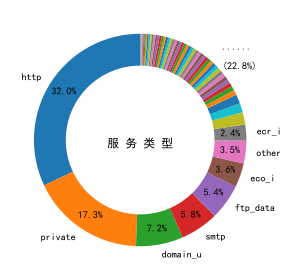

In [10]:
flag = train_data["service"].value_counts().to_dict()
flag = dict(sorted(flag.items(), key=lambda item: item[1], reverse=True))
from matplotlib import cm


others = 0
labels = []
autopct = []
for i in range(len(flag)):
    if i <=7:
        labels.append(list(flag.keys())[i])
        autopct.append(list(flag.values())[i])
    else:
        if i == 20:
            labels.append("......\n\n(22.8%)")
        else :
            labels.append(" ")
        autopct.append(0)
print(autopct)
# 饼图标签
#labels = flag.keys()

# 饼图数据
sizes = flag.values()

# 颜色
#colors = [(44/255,65/255,80/255),(111/255,160/255,172/255), (181/255,211/255,217/255),(93/255,136/255,123/255)]

# 爆炸（可选，用于突出显示某个块）
#explode = (0.0, 0, 0)
def custom_labels(pct):
    if(pct > 2):
        return f'{pct:.1f}%'
    return " "
# 创建饼图
plt.figure(dpi = 300)
plt.pie(sizes,labels=labels, autopct=custom_labels, startangle=90,pctdistance=0.85)#colors=plt.get_cmap('summer')(range(len(sizes)))

# 添加一个中心圆，使饼图看起来更像一个环形图
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# 饼图标题
plt.title('服 务 类 型',loc = 'center',y=0.45)

# 显示饼图
#plt.axis('equal')  # 保证饼图是圆形而不是椭圆
plt.tight_layout()
plt.show()

[4984, 982, 38049, 9034, 7029, 7265]
[1876, 20870, 2289, 9, 284, 33297]
['ftp_data', 'private', 'http', 'domain_u', 'smtp', 'others']


[Text(0, 0, 'ftp_data'),
 Text(1, 0, 'private'),
 Text(2, 0, 'http'),
 Text(3, 0, 'domain_u'),
 Text(4, 0, 'smtp'),
 Text(5, 0, 'others')]

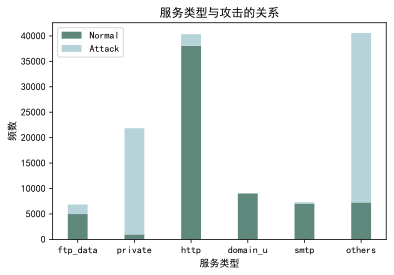

In [11]:
two_df = train_data[["service","outcome"]]
two_df.head()
normal_count = []
attack_count = []
name_list = list(train_data["service"].unique())
for i in name_list:
    normal_count.append(two_df[two_df["service"] == i]["outcome"].value_counts().get("normal",0))
    attack_count.append(len(two_df[two_df["service"] == i]["outcome"])-two_df[two_df["service"] == i]["outcome"].value_counts().get("normal",0))

normal_count_ = []
attack_count_ = []
name_list_ = []
name_vis = ["http","private","domain_u","smtp","ftp_data"]
normal_others = 0
attack_others = 0
for i in range(len(normal_count)):
    if(name_list[i] in name_vis):
        normal_count_.append(normal_count[i])
        attack_count_.append(attack_count[i])
        name_list_.append(name_list[i])
    else:
        normal_others = normal_others + normal_count[i]
        attack_others = attack_others + attack_count[i]
name_list_.append("others") 
normal_count_.append(normal_others)
attack_count_.append(attack_others)
print(normal_count_)
print(attack_count_)
print(name_list_)
categories =    name_list_
bottom_data = normal_count_
top_data = attack_count_



# 创建柱状图
fig, ax = plt.subplots()

# 设置每个柱子的宽度
bar_width = 0.35

# 生成柱子的位置
x = np.arange(len(categories))

# 绘制底部柱子
ax.bar(x, bottom_data, bar_width, label='Normal', color=(93/255,136/255,123/255))

# 绘制顶部柱子，位置稍微向上偏移
ax.bar(x, top_data, bar_width, label='Attack', color=(181/255,211/255,217/255), bottom=bottom_data)

# 添加标签和标题
ax.set_xlabel('服务类型')
ax.set_ylabel('频数')
ax.set_title('服务类型与攻击的关系')

# 添加图例
ax.legend()

# 设置x轴标签
ax.set_xticks(x)
ax.set_xticklabels(categories)

In [12]:
outcome = train_data["outcome"].value_counts().to_dict()
print(outcome)
data_dict = outcome
others_value = 0
keys_to_remove = []
draw_pi_count = 0
for key, value in data_dict.items():
    if (key != "normal"):
        draw_pi_count = draw_pi_count + value
    if value < 100:
        others_value += value
        keys_to_remove.append(key)
for key in keys_to_remove:
    del data_dict[key]
data_dict['others'] = others_value
print(data_dict)
outcome_draw_bar = data_dict


{'normal': 67343, 'neptune': 41209, 'satan': 3633, 'ipsweep': 3599, 'portsweep': 2931, 'smurf': 2646, 'nmap': 1493, 'back': 956, 'teardrop': 892, 'warezclient': 890, 'pod': 201, 'guess_passwd': 53, 'buffer_overflow': 30, 'warezmaster': 20, 'land': 18, 'imap': 11, 'rootkit': 10, 'loadmodule': 9, 'ftp_write': 8, 'multihop': 7, 'phf': 4, 'perl': 3, 'spy': 2}
{'normal': 67343, 'neptune': 41209, 'satan': 3633, 'ipsweep': 3599, 'portsweep': 2931, 'smurf': 2646, 'nmap': 1493, 'back': 956, 'teardrop': 892, 'warezclient': 890, 'pod': 201, 'others': 175}


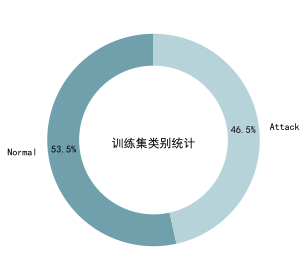

In [13]:
'''
categories = ['Normal', 'Attack']
sizes = [outcome["normal"], draw_pi_count]
plt.figure(dpi = 300)
plt.pie(sizes, labels=categories, autopct='%1.1f%%', startangle=90, colors=[(111/255,160/255,172/255), (181/255,211/255,217/255)])
plt.title('训练集类别统计')
plt.show()
'''


# 饼图标签
categories = ['Normal', 'Attack']
labels = categories

# 饼图数据
sizes = [outcome["normal"], draw_pi_count]

# 颜色
colors = [(111/255,160/255,172/255), (181/255,211/255,217/255)]

# 爆炸（可选，用于突出显示某个块）
explode = (0.0, 0)

# 创建饼图
plt.figure(dpi = 300)
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

# 添加一个中心圆，使饼图看起来更像一个环形图
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# 饼图标题
plt.title('训练集类别统计',loc = 'center',y=0.45)

# 显示饼图
#plt.axis('equal')  # 保证饼图是圆形而不是椭圆
plt.tight_layout()
plt.show()



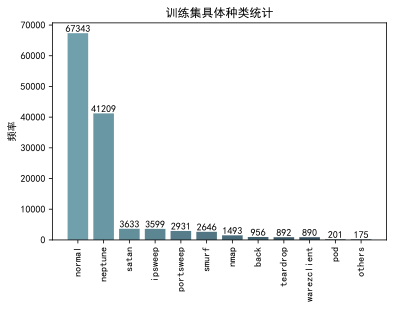

In [14]:
data_dict = outcome_draw_bar
labels = list(data_dict.keys())
values = list(data_dict.values())
colors = generate_gradient_colors((111,160,172),(44,65,80) , len(outcome_draw_bar))
plt.figure(dpi=300)
plt.bar(labels, values, color = colors)
for i in range(len(labels)):
    plt.text(labels[i], values[i], str(values[i]), ha='center', va='bottom')
plt.title('训练集具体种类统计')
plt.ylabel('频率')
plt.xticks(rotation=90)
plt.show()



{'normal': 9710, 'neptune': 4656, 'guess_passwd': 1231, 'mscan': 996, 'warezmaster': 944, 'apache2': 737, 'satan': 735, 'processtable': 685, 'smurf': 665, 'back': 359, 'snmpguess': 331, 'saint': 319, 'mailbomb': 293, 'snmpgetattack': 178, 'portsweep': 157, 'ipsweep': 141, 'httptunnel': 133, 'nmap': 73, 'pod': 41, 'buffer_overflow': 20, 'multihop': 18, 'named': 17, 'ps': 15, 'sendmail': 14, 'rootkit': 13, 'xterm': 13, 'teardrop': 12, 'xlock': 9, 'land': 7, 'xsnoop': 4, 'ftp_write': 3, 'worm': 2, 'loadmodule': 2, 'perl': 2, 'sqlattack': 2, 'udpstorm': 2, 'phf': 2, 'imap': 1}
{'normal': 9710, 'neptune': 4656, 'guess_passwd': 1231, 'mscan': 996, 'warezmaster': 944, 'apache2': 737, 'satan': 735, 'processtable': 685, 'smurf': 665, 'back': 359, 'snmpguess': 331, 'saint': 319, 'mailbomb': 293, 'snmpgetattack': 178, 'portsweep': 157, 'ipsweep': 141, 'httptunnel': 133, 'others': 272}


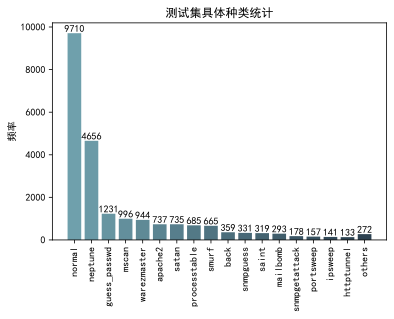

In [15]:
outcome = test_data["outcome"].value_counts().to_dict()
print(outcome)
data_dict = outcome
others_value = 0
keys_to_remove = []
draw_pi_count = 0
for key, value in data_dict.items():
    if (key != "normal"):
        draw_pi_count = draw_pi_count + value
    if value < 100:
        others_value += value
        keys_to_remove.append(key)
for key in keys_to_remove:
    del data_dict[key]
data_dict['others'] = others_value
print(data_dict)
outcome_draw_bar = data_dict

labels = list(data_dict.keys())
values = list(data_dict.values())
colors = generate_gradient_colors((111,160,172),(44,65,80) , len(outcome_draw_bar))
plt.figure(dpi=300)
plt.bar(labels, values, color = colors)
for i in range(len(labels)):
    plt.text(labels[i], values[i], str(values[i]), ha='center', va='bottom')
plt.title('测试集具体种类统计')
plt.ylabel('频率')
plt.xticks(rotation=90)
plt.show()


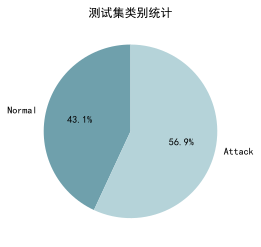

In [16]:
categories = ['Normal', 'Attack']
sizes = [outcome["normal"], draw_pi_count]
plt.figure(dpi = 300)
plt.pie(sizes, labels=categories, autopct='%1.1f%%', startangle=90, colors=[(111/255,160/255,172/255), (181/255,211/255,217/255)])
plt.title('测试集类别统计')
plt.show()



In [17]:
columns_set1 = set(train_data['outcome'])
columns_set2 = set(test_data['outcome'])

# 找到 df1 中不在 df2 中的列
columns_diff1 = columns_set1 - columns_set2

# 找到 df2 中不在 df1 中的列
columns_diff2 = columns_set2 - columns_set1

# 打印结果
print("Columns in df1 but not in df2:", columns_diff1)
print("Columns in df2 but not in df1:", columns_diff2)

Columns in df1 but not in df2: {'spy', 'warezclient'}
Columns in df2 but not in df1: {'processtable', 'mailbomb', 'worm', 'snmpguess', 'snmpgetattack', 'mscan', 'apache2', 'xlock', 'httptunnel', 'ps', 'udpstorm', 'xsnoop', 'sqlattack', 'named', 'saint', 'xterm', 'sendmail'}


{'processtable': 685, 'mailbomb': 293, 'worm': 2, 'snmpguess': 331, 'snmpgetattack': 178, 'mscan': 996, 'apache2': 737, 'xlock': 9, 'httptunnel': 133, 'ps': 15, 'udpstorm': 2, 'xsnoop': 4, 'sqlattack': 2, 'named': 17, 'saint': 319, 'xterm': 13, 'sendmail': 14}


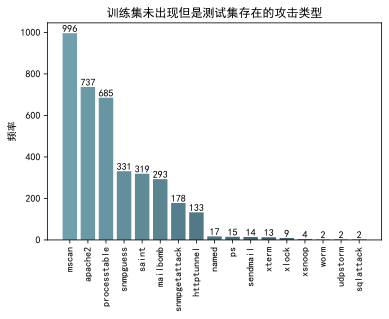

3750


In [18]:
temp = 0
test_dict = test_data['outcome'].value_counts().to_dict()
only_in_test = {}
for i in list(columns_diff2):
    only_in_test[i] = test_dict[i]
print(only_in_test)

data_dict = dict(sorted(only_in_test.items(), key=lambda item: item[1], reverse=True))  # 按值升序排序
labels = list(data_dict.keys())
values = list(data_dict.values())
colors = generate_gradient_colors((111,160,172),(44,65,80) , len(outcome_draw_bar))
plt.figure(dpi=300)
plt.bar(labels, values, color = colors)
for i in range(len(labels)):
    plt.text(labels[i], values[i], str(values[i]), ha='center', va='bottom')
    temp= temp+values[i]
plt.title('训练集未出现但是测试集存在的攻击类型')
plt.ylabel('频率')
plt.xticks(rotation=90)
plt.show()
print(temp)

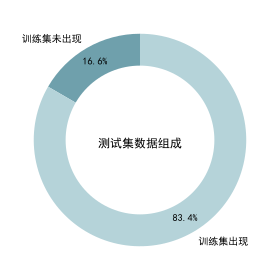

In [19]:
categories = ['训练集未出现', '训练集出现']
'''
sizes = [sum(data_dict.values()), sum(test_dict.values())]
plt.figure(dpi = 300)
plt.pie(sizes, labels=categories, autopct='%1.1f%%', startangle=90, colors=[(111/255,160/255,172/255), (181/255,211/255,217/255)])
plt.title('测试集中攻击类型统计')
plt.show()
'''
labels = categories

# 饼图数据
sizes = [3750, 22542-3750]

# 颜色
colors = [(111/255,160/255,172/255), (181/255,211/255,217/255)]

# 爆炸（可选，用于突出显示某个块）
explode = (0.0, 0)

# 创建饼图
plt.figure(dpi = 300)
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

# 添加一个中心圆，使饼图看起来更像一个环形图
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# 饼图标题
plt.title('测试集数据组成',loc = 'center',y=0.45)

# 显示饼图
#plt.axis('equal')  # 保证饼图是圆形而不是椭圆
plt.tight_layout()
plt.show()


